# Applying explainability techniques (and 'action analysis') to RL-trained models' responses to dataset images

# Imports

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
# sf imports for environment and extracting encoder etc.
from retinal_rl.helpers import get_cfg_jupyter

from retinal_rl.system.environment import register_retinal_environment
from retinal_rl.system.encoders import register_encoders

from retinal_rl.analysis.util import get_env_ac, simulate, load_sim_out, get_acts_dataset, unroll_conv_acts
from retinal_rl.analysis.plot import save_simulation_gif, plot_all_rf, plot_acts_tsne_stim, plot_dimred_ds_acts, save_activations_gif, plot_dimred

from retinal_rl.analysis.statistics import fit_tsne,fit_pca


# automatic reloading
%load_ext autoreload
%autoreload 2

/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# imports for explainability
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from captum.attr import Saliency, GuidedBackprop, Occlusion

from copy import deepcopy
from torch import nn

# imports from sf required to refactor sf to 'pure pytorch'
from sample_factory.algorithms.appo.model_utils import get_hidden_size
from sample_factory.utils.utils import log, AttrDict
from sample_factory.algorithms.appo.actor_worker import transform_dict_observations
from sample_factory.algorithms.utils.algo_utils import EPS # weird dependency?
from sample_factory.algorithms.utils.action_distributions import get_action_distribution

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda:0


In [4]:
from retinal_rl.analysis.util import PaddedMnistDataset, PytorchActorCritic
from retinal_rl.analysis.util import pad_dataset_attribution, get_padded_mnist, get_all_action
from retinal_rl.analysis.plot import plot_fov_att_overlay_avg, plot_fov_att_overlay_rgb, plot_fov_att_overlay_avg, plot_att_action, plot_example_stim_torch, plot_violin_action

# Setting parameters

In [5]:
# choose dataset
experiment = 'postcosyne_complicated_mnist_nornn_01'
a_or_c = 'a' # analyze actor or critic?
analyze_ds_name = 'MNIST'
downs_fact = 1 # 1 for no downsampling
mnist_offset = (50,46) # pixel offset of where the stimulus is rendered within the 'doom pad'
get_raw_logits = False # keep this as False for visualising probabilities of actions and make it True to visualise action embedding

## Start of script

In [6]:
register_retinal_environment()
register_encoders()
cfg = get_cfg_jupyter(experiment) # this is not needed in script

cfg.res_h = 90
cfg.res_w = 120
cfg.a_or_c = a_or_c
cfg.analyze_ds_name = analyze_ds_name

[2022-12-22 09:44:18,812][49341] Default env families supported: ['doom_*', 'atari_*', 'dmlab_*', 'mujoco_*', 'MiniGrid*']
[2022-12-22 09:44:18,813][49341] Env registry entry created: retinal_
[2022-12-22 09:44:18,815][49341] Adding model class <class 'retinal_rl.system.encoders.LindseyEncoder'> to registry (with name lindsey)


--env=retinal_mnist_gathering_01
--vvs_depth=1
--algo=APPO
--experiment=postcosyne_complicated_mnist_nornn_01
--global_channels=16
--retinal_bottleneck=4
--analyze_acts=False
--res_h=90
--res_w=120


In [7]:
env, actor_critic = get_env_ac(cfg)
simulate(cfg, env, actor_critic) # this saves

# backing up for later comparison to the refactored ac
actor_critic_backup = deepcopy(actor_critic)

[2022-12-22 09:44:18,979][49341] Loading existing experiment configuration from /gpfs01/berens/user/jmajnik/retinal-rl/train_dir/postcosyne_complicated_mnist_nornn_01/cfg.json
[2022-12-22 09:44:18,980][49341] Adding new argument 'render_action_repeat'=None that is not in the saved config file!
[2022-12-22 09:44:18,981][49341] Adding new argument 'no_render'=False that is not in the saved config file!
[2022-12-22 09:44:18,982][49341] Adding new argument 'policy_index'=0 that is not in the saved config file!
[2022-12-22 09:44:18,983][49341] Adding new argument 'record_to'='/gpfs01/berens/user/jmajnik/retinal-rl/../recs' that is not in the saved config file!
[2022-12-22 09:44:18,983][49341] Adding new argument 'continuous_actions_sample'=True that is not in the saved config file!
[2022-12-22 09:44:18,984][49341] Adding new argument 'a_or_c'='a' that is not in the saved config file!
[2022-12-22 09:44:18,985][49341] Using action repeat 4 during evaluation
[2022-12-22 09:44:18,992][49341] Do

LindseyEncoder(
  (activation): ELU(alpha=1.0, inplace=True)
  (nl_fc): ELU(alpha=1.0, inplace=True)
  (conv_head): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (fc1): Linear(in_features=21600, out_features=64, bias=True)
  (base_encoder): LindseyEncoderBase(
    (activation): ELU(alpha=1.0, inplace=True)
    (nl_fc): ELU(alpha=1.0, inplace=True)
    (conv_head): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
      (1): ELU(alpha=1.0, inplace=True)
      (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
      (3): ELU(alpha=1.0, inplace=True)
      (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
      (5): ELU(alpha=1.0, inplace=True)
    )
    (fc1): Linear(in_features=21600, out_features=64, b

[2022-12-22 09:44:21,046][49341] Loading state from checkpoint /gpfs01/berens/user/jmajnik/retinal-rl/train_dir/postcosyne_complicated_mnist_nornn_01/checkpoint_p0/checkpoint_001220705_10000015360.pth...


Simulated 100 / 1000 environment steps.
Simulated 200 / 1000 environment steps.
Simulated 300 / 1000 environment steps.
Simulated 400 / 1000 environment steps.
Simulated 500 / 1000 environment steps.
Simulated 600 / 1000 environment steps.
Simulated 700 / 1000 environment steps.
Simulated 800 / 1000 environment steps.
Simulated 900 / 1000 environment steps.
Simulated 1000 / 1000 environment steps.


### Prepare dataset and re-defined pure pytorch actor-critic class

In [8]:
padded_ds = get_padded_mnist(cfg, downs_fact=downs_fact, mnist_offset=mnist_offset)

tcmalloc: large alloc 7776002048 bytes == 0x559abfb28000 @ 


In [9]:
# initializing actor critic and preparing for explainability
actor_critic = PytorchActorCritic(cfg, actor_critic_backup)

actor_critic.eval()
actor_critic.to(device)

PytorchActorCritic(
  (conv_head): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (fc1): Linear(in_features=21600, out_features=64, bias=True)
  (nl_fc): ELU(alpha=1.0, inplace=True)
  (critic): Linear(in_features=64, out_features=1, bias=True)
  (actor): Linear(in_features=64, out_features=6, bias=True)
)

### Finally testing saliency of AC trained on RL

In [10]:
# initialising attribution method
att_method = GuidedBackprop(actor_critic) # this can be swapped to use for example saliency: att_method = Saliency(actor_critic)

/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


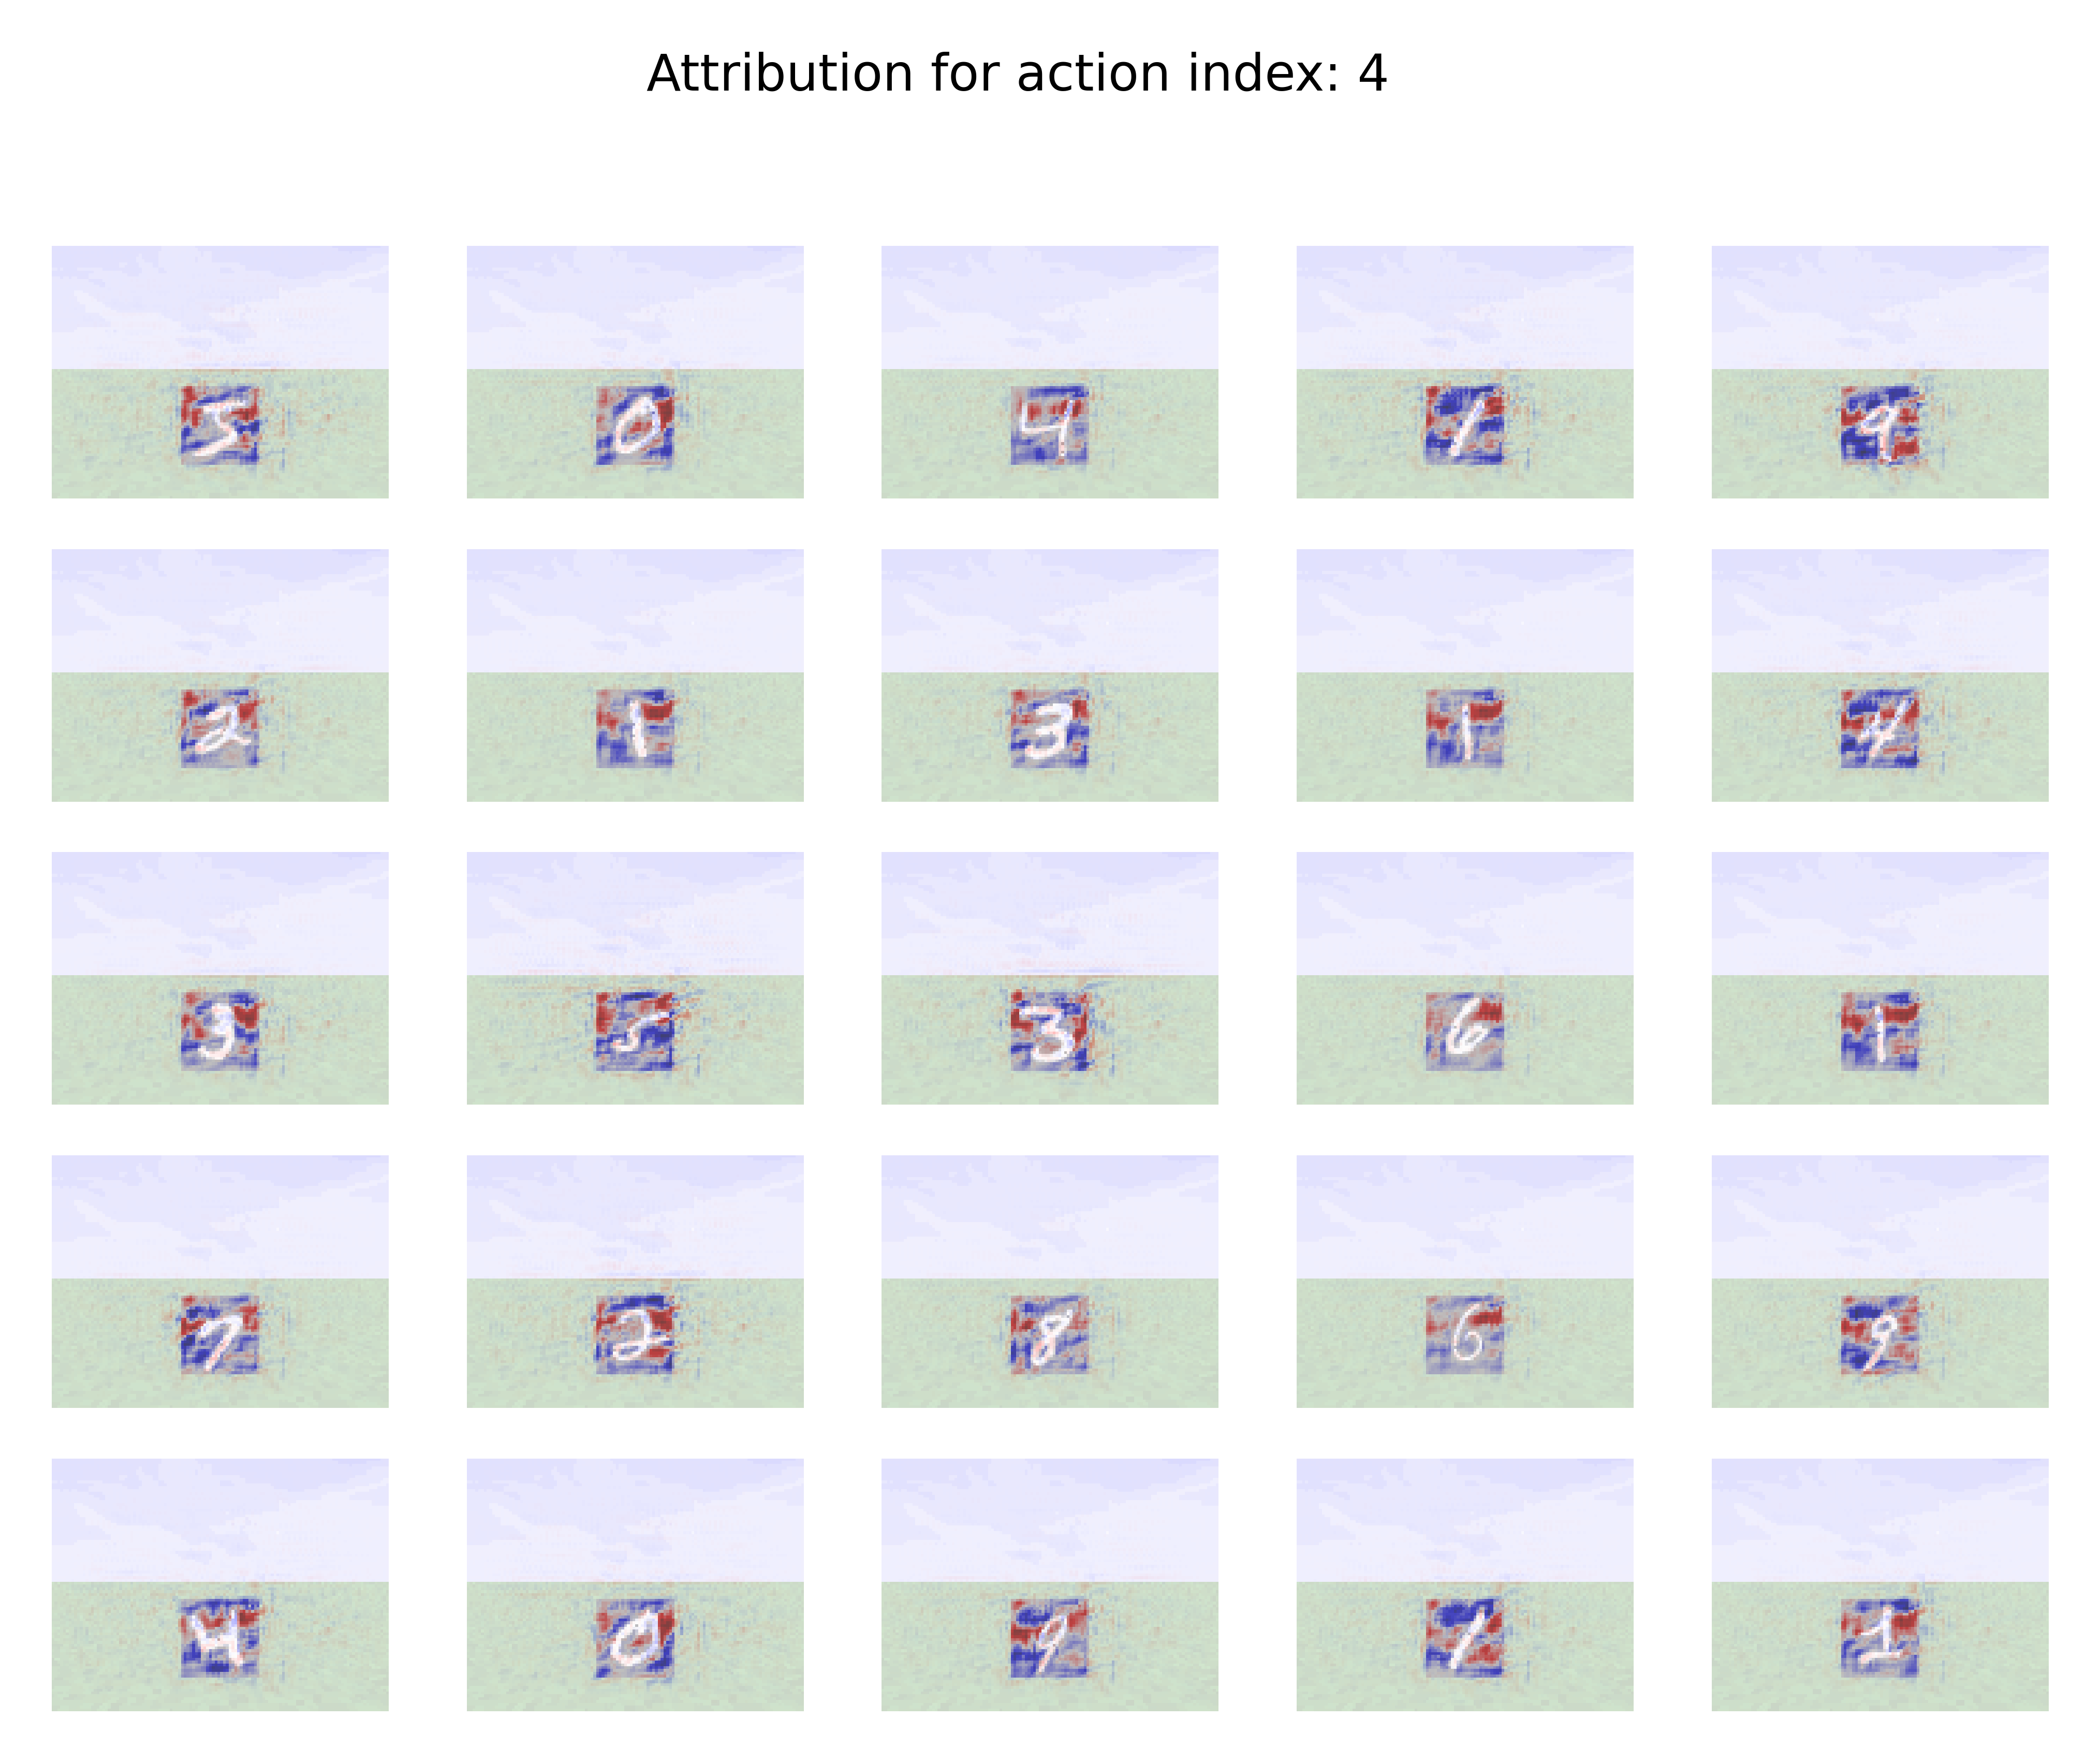

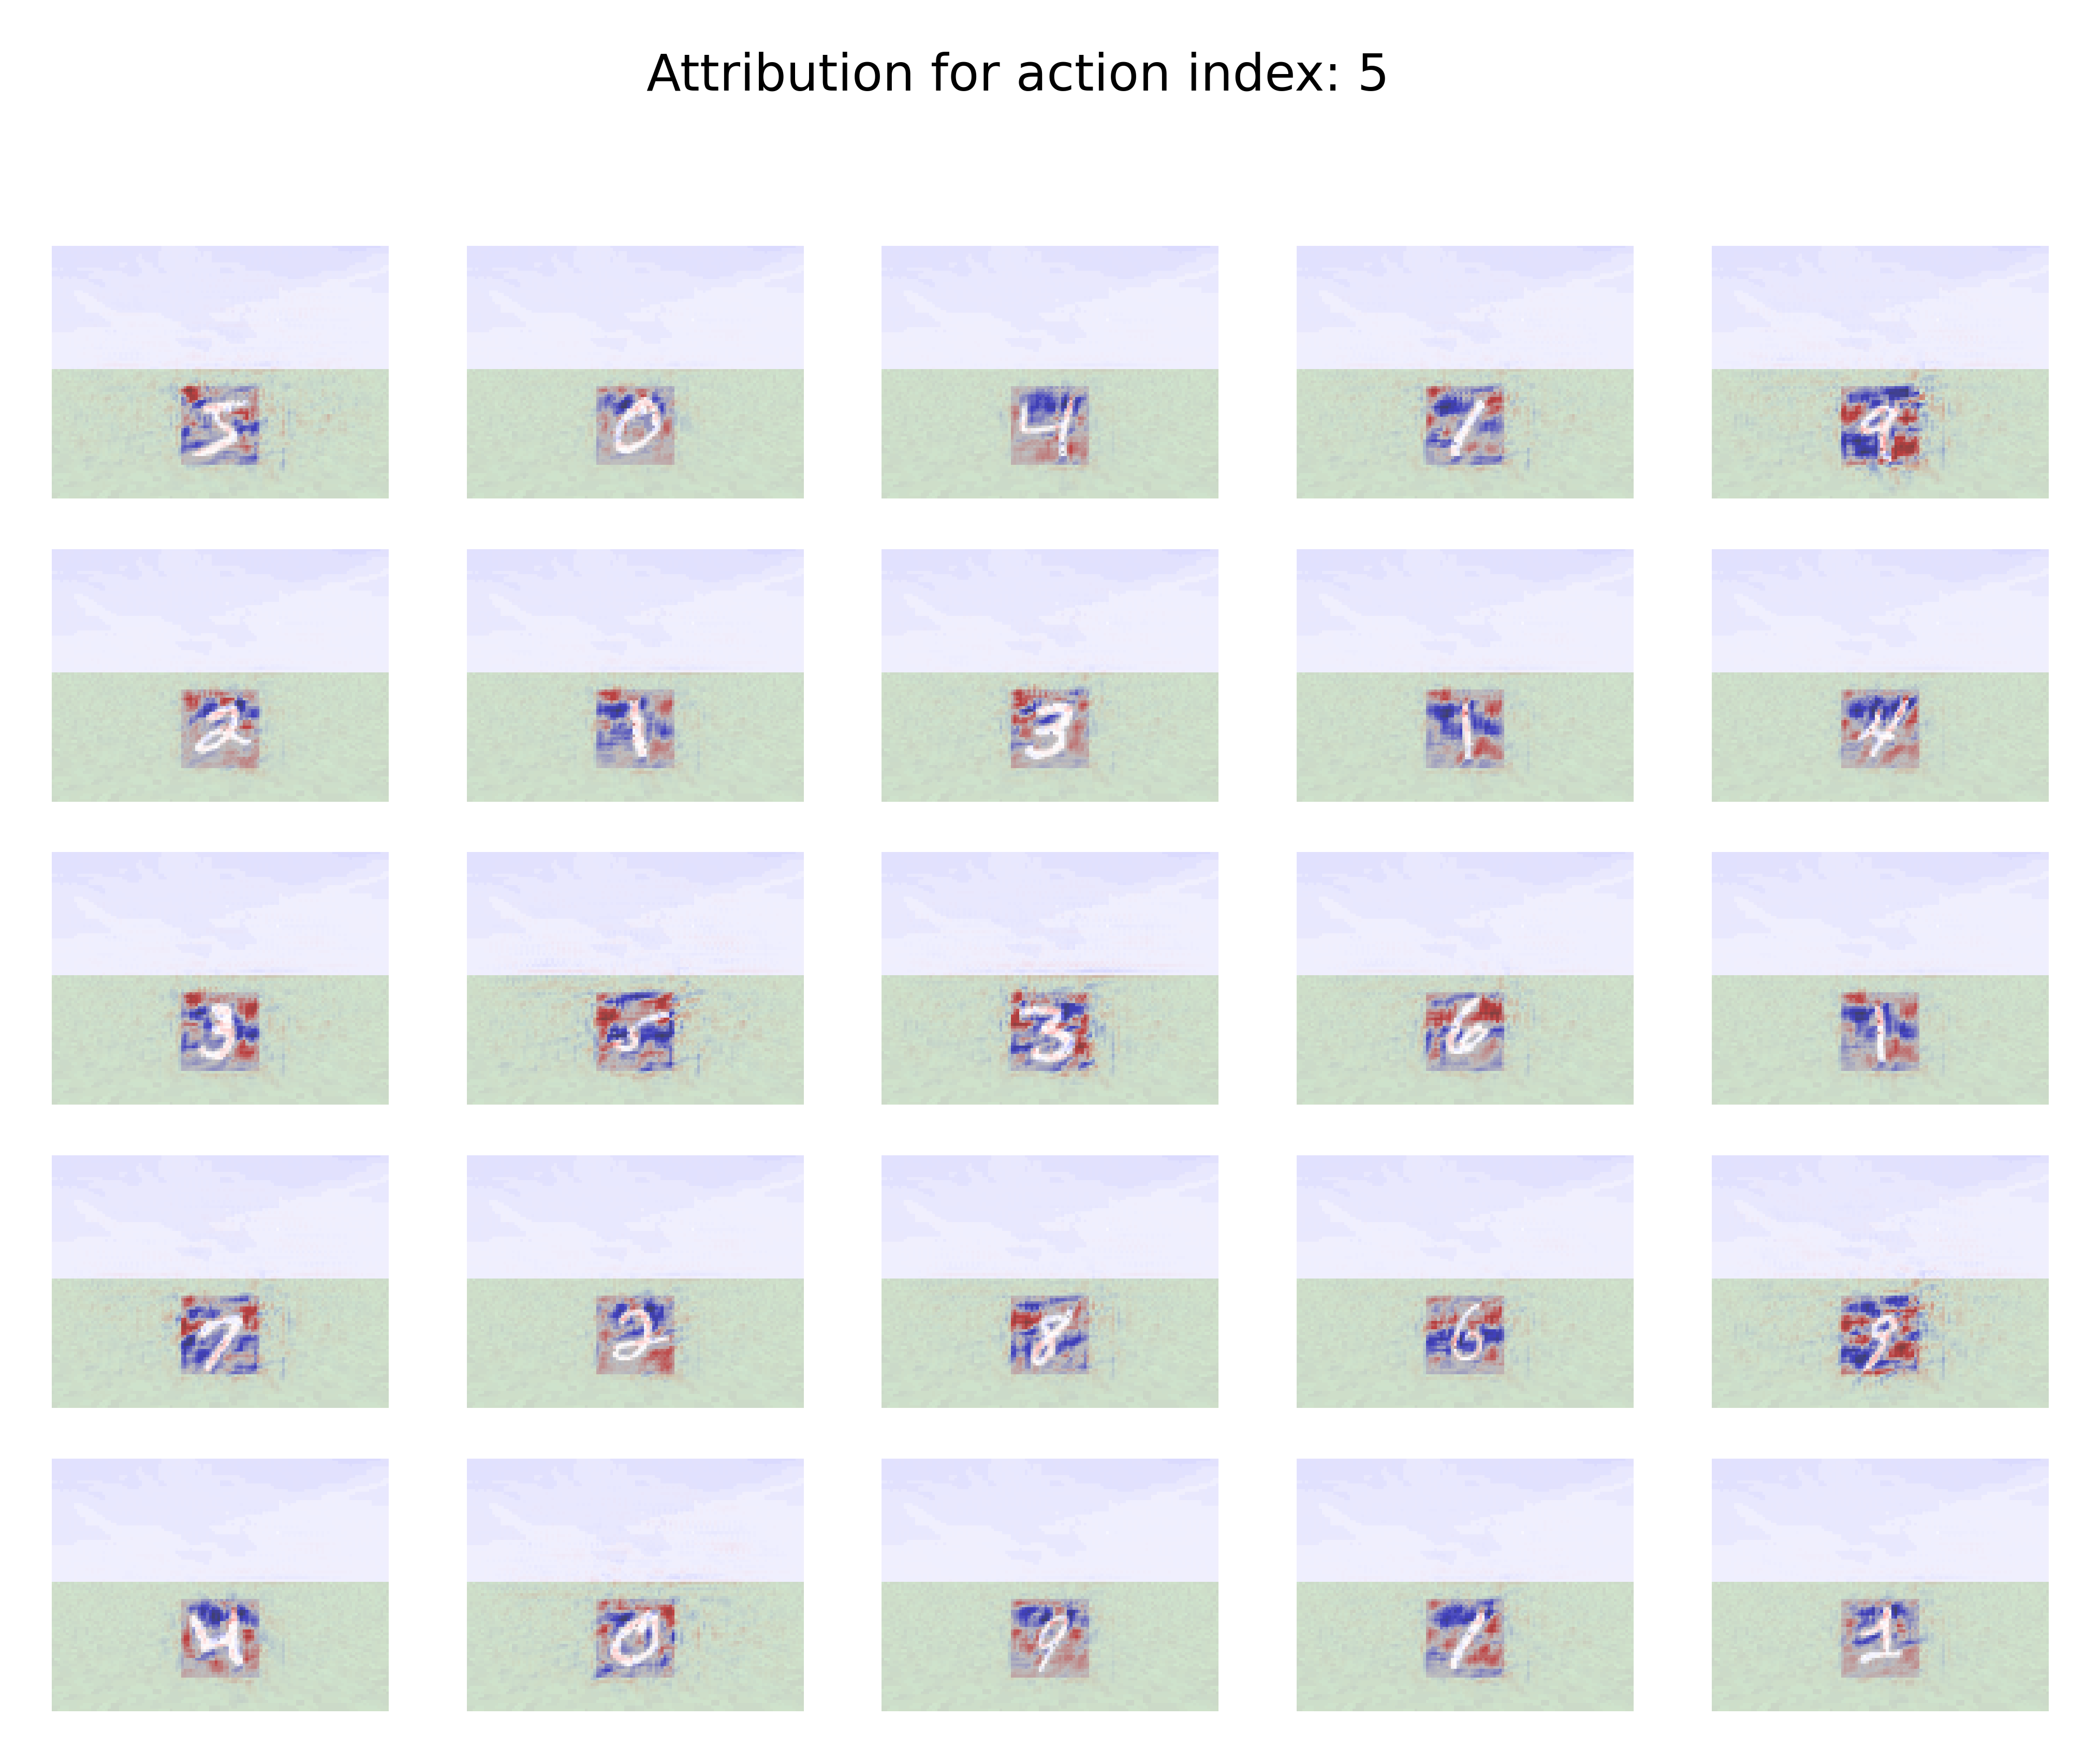

In [11]:
# plot a few example attributions for hard-coded action (here 4 is walking forward and 5 is walking backward) with a chosen attribution method
plot_att_action(padded_ds, att_method=att_method, action_idx=4)
plot_att_action(padded_ds, att_method=att_method, action_idx=5)

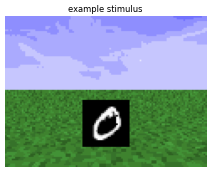

In [12]:
plot_example_stim_torch(padded_ds[1][0])

In [13]:
all_action, all_label = get_all_action(cfg, env, padded_ds, actor_critic, get_raw_logits=get_raw_logits)

fitting PCA...


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: juremaj. Use `wandb login --relogin` to force relogin


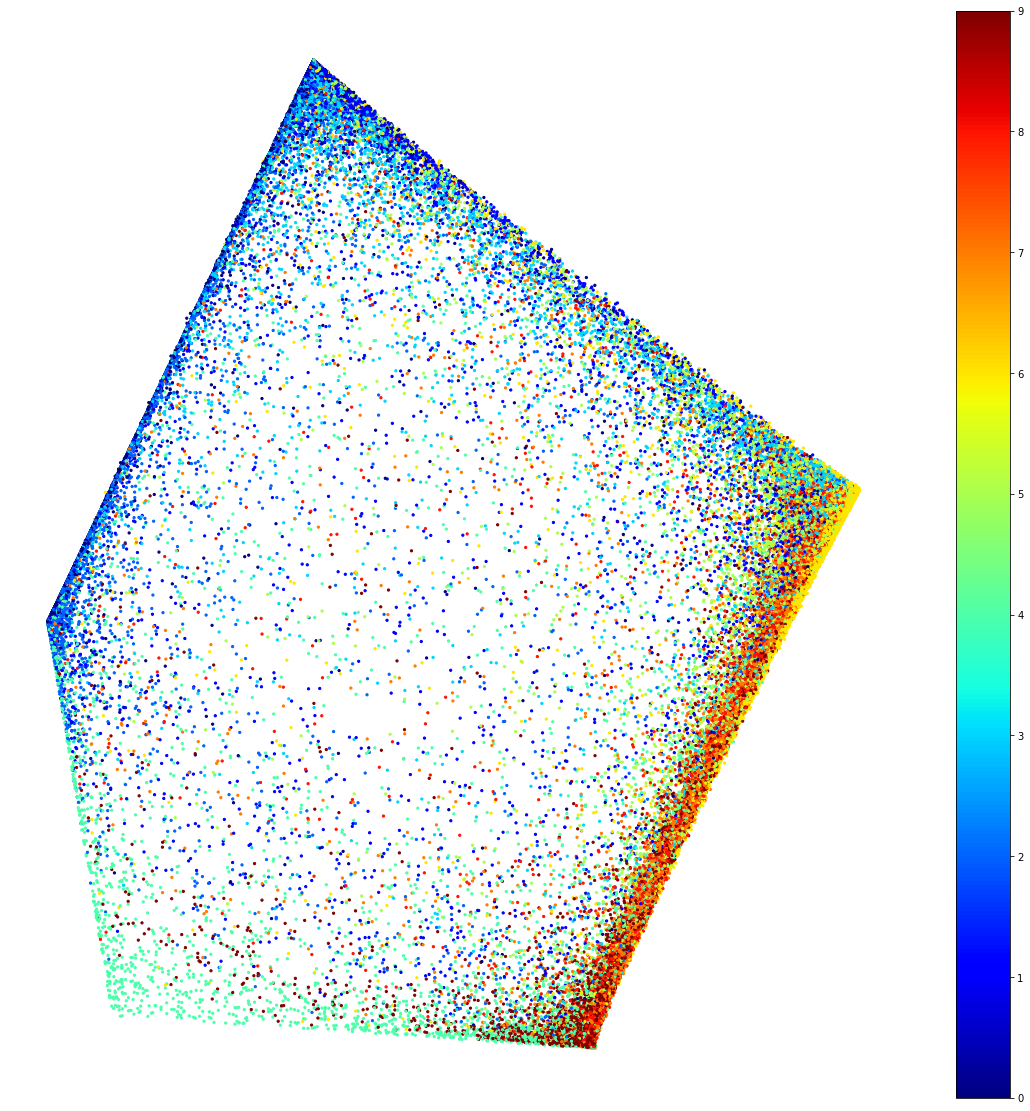

In [14]:
pca_emb = fit_pca(all_action)[0]
plot_dimred(cfg, pca_emb, all_label, title='tsne_actions')

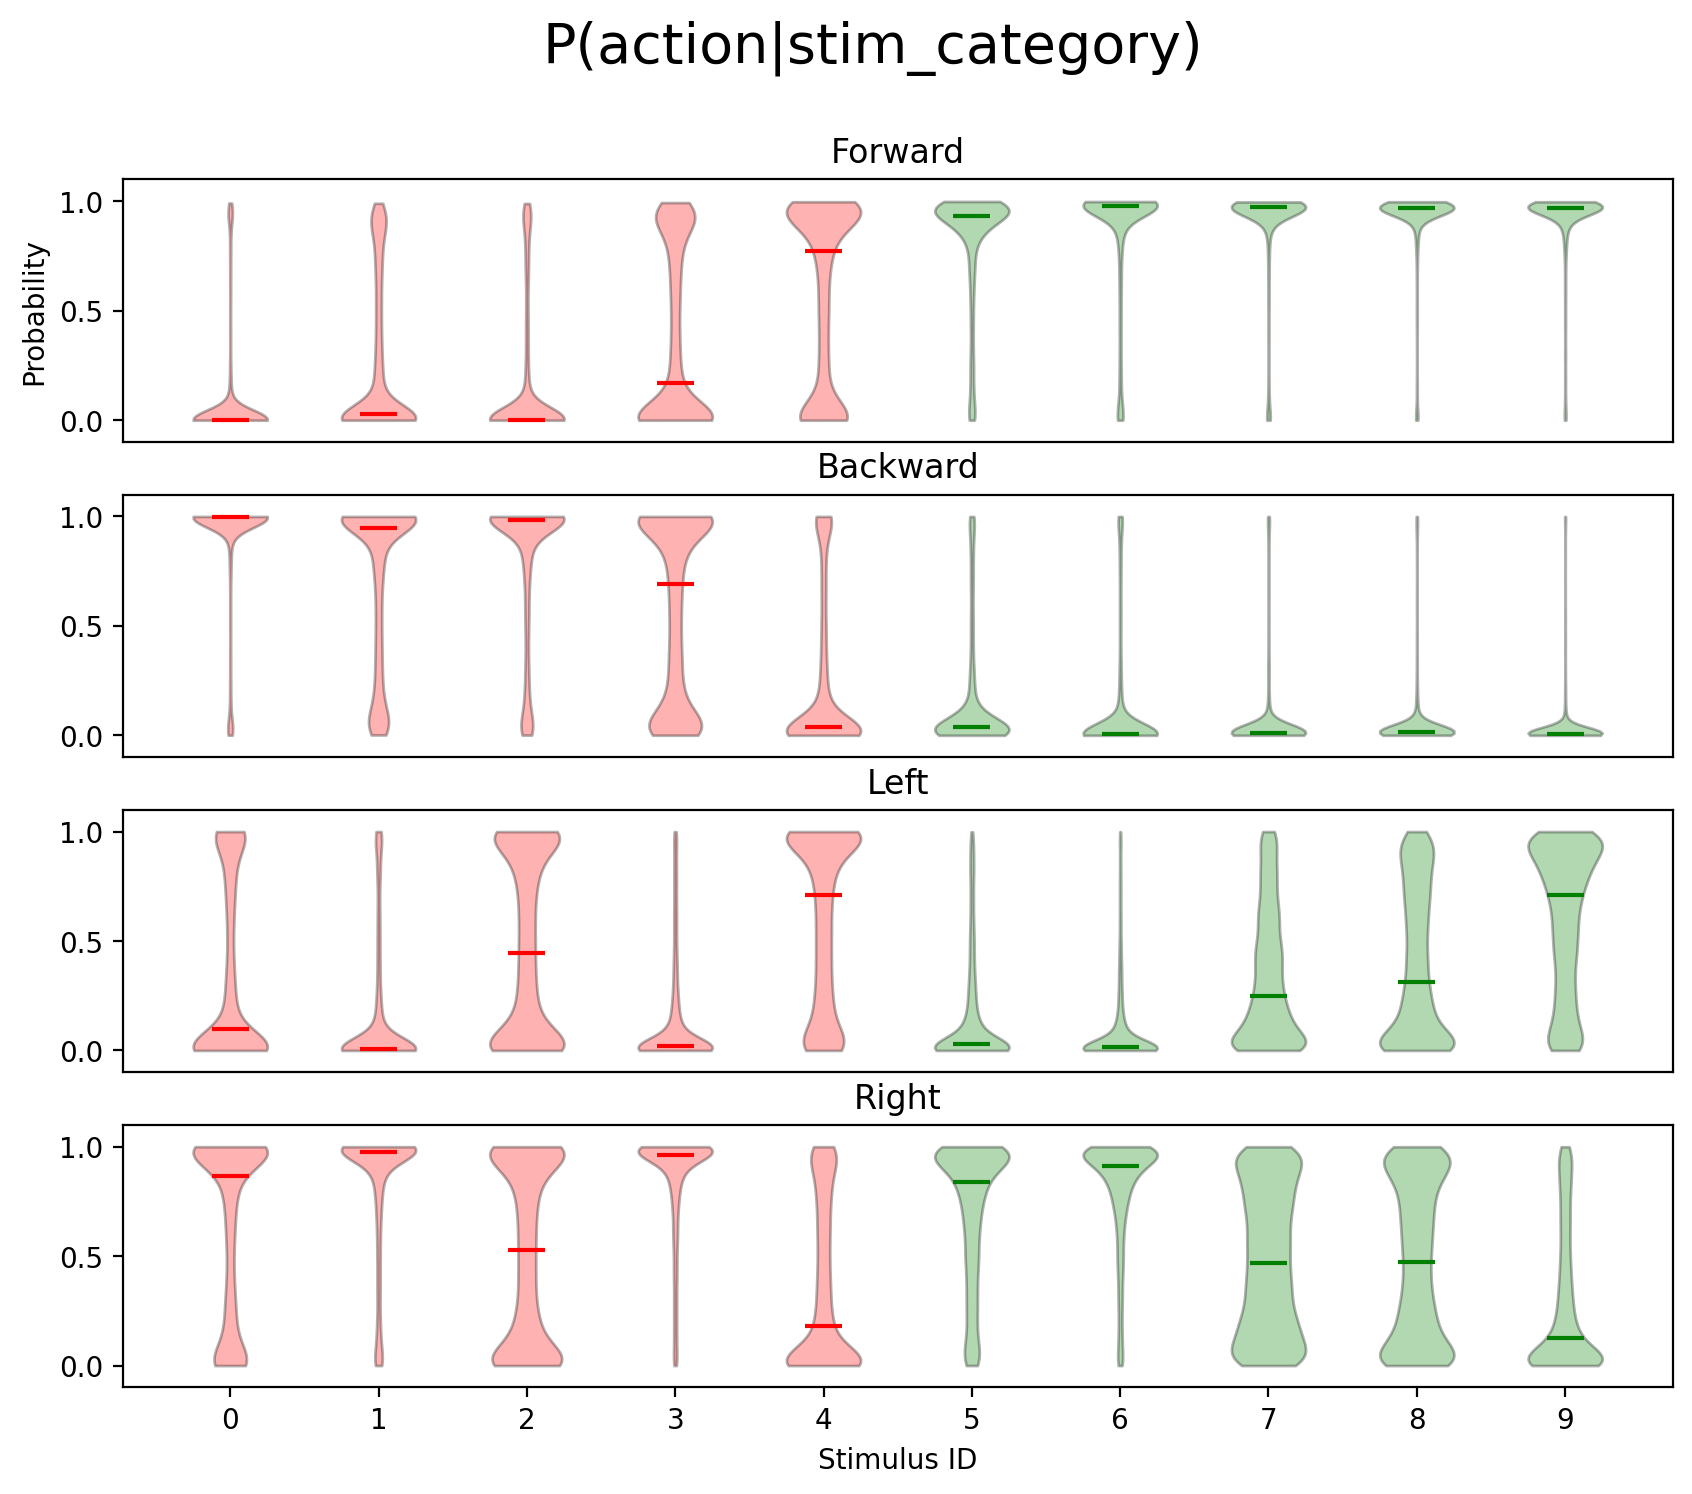

In [15]:
plot_violin_action(all_action, all_label)